In [155]:
import os
import sys
import subprocess
import string
import re
import pygraphviz as pgv
from IPython.display import Image, display

Copy the sequencial log lines in the box below. For example:

2020-10-04T18:11:00.290549583Z stderr F I1004 18:11:00.290407       1 pv_protection_controller.go:183] Removed protection finalizer from PV pv1
2020-10-04T18:11:00.292629856Z stderr F I1004 18:11:00.291870       1 pv_protection_controller.go:128] Finished processing PV pv1 (7.315056ms)
2020-10-04T18:11:00.292758811Z stderr F I1004 18:11:00.291618       1 pv_controller_base.go:230] volume "pv1" deleted

In [160]:
lines = """
2020-10-04T18:11:00.290549583Z stderr F I1004 18:11:00.290407       1 pv_protection_controller.go:183] Removed protection finalizer from PV pv1
2020-10-04T18:11:00.292629856Z stderr F I1004 18:11:00.291870       1 pv_protection_controller.go:128] Finished processing PV pv1 (7.315056ms)
2020-10-04T18:11:00.292758811Z stderr F I1004 18:11:00.291618       1 pv_controller_base.go:230] volume "pv1" deleted
"""

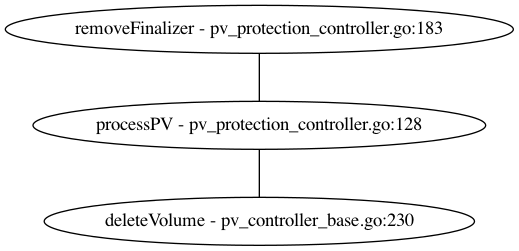

In [163]:
package = os.path.expanduser("~") + "/go/src/k8s.io/kubernetes/pkg"

file_paths = {}


def extract_name(line):
    return re.findall(r"(\w+)\(", line)[0]
    

def get_function_file(full_path, line_num):
    fd, function = open(full_path), ""
    for num, line in enumerate(fd.readlines()):
        if int(line_num) == num:
            break
        if "func " in line and "func()" not in line:
            function = extract_name(line)
    return function


def extract_function(path, filename, line):
    function = None
    
    for fd in os.listdir(path):        
        full_path = os.path.join(path, fd)
        if os.path.isdir(full_path):
            result = extract_function(full_path, filename, line)
            function = result if result else function
        elif filename == fd:
            return get_function_file(full_path, line)
    return function


def extract_file_line(line):
    if not line: 
        return 0, 0 
    regex = r"(?P<filename>\w+\.\w+):(?P<line>\d+)\]"
    return re.findall(regex, line)[0]


def extract_lines(lines):
    events = []
    for line in lines.split("\n"):
        filename, line = extract_file_line(line)
        if filename and line:
            func = extract_function(package, filename, line)
            events.append((func, filename, line))
    return events


def node_name(event):
    return f"{event[0]} - {event[1]}:{event[2]}"

    
def mount_graphs():
    
    events = extract_lines(lines)
    G = pgv.AGraph()

    for idx, event in enumerate(events):
        name = node_name(event)
        G.add_node(name)

        if idx + 1 == len(events):
            continue

        next_node = events[idx + 1]
        G.add_edge(name, node_name(next_node))
                       
    return G

graph = mount_graphs()
graph.layout('dot')
graph.draw("graph.png")
display(Image("graph.png"))